In [ ]:
%%bash
cd ..
rm -rf content
ln -s /drive/MyDrive/cs182_project content
cd content

pip install -r requirements.txt

In [ ]:
from google.colab import drive
drive.mount('/drive')

In [ ]:
%%bash
cd ..
rm -rf content
ln -s /drive/MyDrive/cs182_project content
cd content

pip install -r requirements.txt

# RESTART YOUR RUNTIME NOW!

In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer

In [2]:
# Key Hyperparameters
enable_orig = True
enable_aug = False
enable_aug3 = False
max_training_samples = 100000
max_tokenized_length = 64
num_sentences = 10

batch_size = 128
batch_size_finetuning = 8
epochs = 20
epochs_finetuning = 1

experiment_id = f"classification-lstm-of-sentences-finetuned-bert-{max_training_samples}-orig-data-{epochs}-epochs"

In [3]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
assert not os.path.exists(experiment_dir)
os.makedirs(experiment_dir)

In [4]:
from data_parsing import load_dataset, load_gen_dataset
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [5]:
from training_utils import split_train_validation
train_x, valid_x, train_y, valid_y = split_train_validation(data, 0.01)

if not enable_orig:
    train_x = []
    train_y = []

if enable_aug:
    aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
    train_x += [i[0] for i in aug_data]
    train_y += [i[1] for i in aug_data]

if enable_aug3:
    aug_data3 = load_gen_dataset("./new_data3.json")
    train_x += [i[0] for i in aug_data3]
    train_y += [i[1] for i in aug_data3]

In [6]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

528245
528245
5336
5336


In [7]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [8]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [9]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x[:max_training_samples]))):
        doc = nlp(text)
        sents = list(doc.sents)
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(str(sentence), truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = list(doc.sents)
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(str(sentence), truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    f"{experiment_dir}/training_data_finetuning"
)

100%|██████████| 5336/5336 [00:03<00:00, 1347.02it/s]


In [10]:
from model import ReviewPredictionModel
import torch.optim as optim

model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length)
model_to_train_finetuning.transformer = embedding_bert
model_to_train_finetuning.to(device)
optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=1e-5)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [11]:
from training_utils import run_training_loop

training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
    model_to_train_finetuning, optimizer, device,
    batch_size_finetuning, epochs_finetuning,
    train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
    model_id=experiment_id, tag="finetuning"
)

from utils import memo_load
(training_accuracies_finetuning, validation_accuracies_finetuning) = memo_load(
    lambda: (training_accuracies_finetuning, validation_accuracies_finetuning),
    f"{experiment_dir}/training_validation_accuracies_finetuning"
)

Epoch: 0 Iteration: 68511 Loss: 0.864 Validation Loss: 0.923 Accuracy: 0.600 Validation Accuracy: 0.688:  92%|█████████▏| 68511/74223 [1:22:04<07:00, 13.59it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch: 0 Iteration: 74222 Loss: 0.876 Validation Loss: 0.954 Accuracy: 0.613 Validation Accuracy: 0.695: 100%|██████████| 74223/74223 [1:28:54<00:00, 13.91it/s]


Saving BERT model to ./bert_model_save_from_training/classification-lstm-of-sentences-finetuned-bert-100000-orig-data-20-epochs/


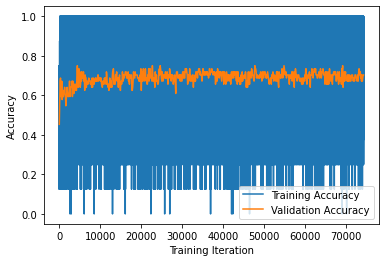

In [12]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(f"{experiment_dir}/training-plot-finetuning.png")

In [13]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = list(doc.sents)
        for sentence in sents[:num_sentences]:
            sentence = str(sentence)
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            with th.no_grad():
                sentence_tensor = th.tensor(tokenized.ids).unsqueeze(0).to(device)
                concatted = np.concatenate([
                    # take output corresponding to CLS
                    embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].flatten().cpu().numpy(),
                    [0]
                ])
                if not concatted_shape:
                    concatted_shape = concatted.shape
                    pad_value = np.zeros(concatted_shape)
                    pad_value[-1] = 1
                embeddeds.append(concatted)
        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))
        embeds.append(embeddeds)
    return np.array(embeds)

from utils import memo_load
train_x_embeds = memo_load(lambda: get_embeds(train_x[:max_training_samples]), f"{experiment_dir}/training_data")
valid_x_embeds = memo_load(lambda: get_embeds(valid_x), f"{experiment_dir}/valid_data")

100%|██████████| 5336/5336 [03:31<00:00, 25.19it/s]


In [14]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

print(train_x_embeds.shape)

model_to_train = None
model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], train_x_embeds.shape[2])
model_to_train.to(device)
optimizer = optim.Adam(model_to_train.parameters(), lr=1e-5)

(100000, 10, 769)


In [15]:
from training_utils import run_training_loop

from utils import memo_load
(training_accuracies, validation_accuracies) = memo_load(
    lambda: run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id
    ),
    f"{experiment_dir}/training_validation_accuracies"
)

Epoch: 0 Iteration: 781 Loss: 0.491 Validation Loss: 0.589 Accuracy: 0.795 Validation Accuracy: 0.693: 100%|██████████| 782/782 [00:10<00:00, 74.91it/s]
Epoch: 1 Iteration: 781 Loss: 0.495 Validation Loss: 0.588 Accuracy: 0.800 Validation Accuracy: 0.714: 100%|██████████| 782/782 [00:10<00:00, 74.70it/s]
Epoch: 2 Iteration: 781 Loss: 0.476 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.733: 100%|██████████| 782/782 [00:10<00:00, 74.87it/s]
Epoch: 3 Iteration: 781 Loss: 0.452 Validation Loss: 0.559 Accuracy: 0.815 Validation Accuracy: 0.741: 100%|██████████| 782/782 [00:10<00:00, 74.74it/s]
Epoch: 4 Iteration: 781 Loss: 0.451 Validation Loss: 0.567 Accuracy: 0.819 Validation Accuracy: 0.758: 100%|██████████| 782/782 [00:10<00:00, 74.83it/s]
Epoch: 5 Iteration: 781 Loss: 0.464 Validation Loss: 0.556 Accuracy: 0.820 Validation Accuracy: 0.753: 100%|██████████| 782/782 [00:10<00:00, 74.87it/s]
Epoch: 6 Iteration: 781 Loss: 0.491 Validation Loss: 0.584 Accuracy: 0.780 Validat

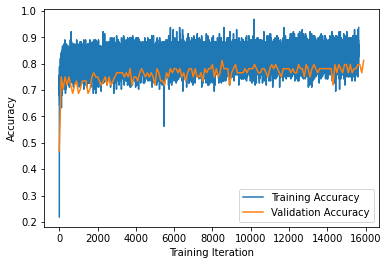

In [16]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(f"{experiment_dir}/training-plot.png")